# GeoPandas

### Description

>The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

***
First we set up the tools we will be using in this notebook.
1. `pandas` for reading in the CSV file containing information about 2,797 4-year institution across the United States.
2. `geopandas` for working with geospatial data.
3. `geoplot` to more easily create nice-looking maps with geopandas.
4. `pathlib.Path` so that the filepaths work regardless of your operating system.
5. `tools.tree`, you may notice there's a `tools.py` script in our notebooks folder. It includes a `tree` function that helps us display the contents of a directory.

In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from pathlib import Path
from tools import tree

%matplotlib inline

We include the `magic` 
```python
%matplotlib inline
```
to display our `matplotlib` plots in our jupyter notebook.

In [2]:
DATA_DIRECTORY = Path("../data/")

In [3]:
tree(DATA_DIRECTORY)

+ ..\data
    + external
        + Data_10-3-2019---695.csv
        + ValueLabels_10-3-2019---695.csv
    + interim
    + processed
        + colleges_in_US.csv
    + raw


In our `data/external/` folder you'll find the data as it comes from [IPEDS](https://nces.ed.gov/ipeds/) (Integrated Postsecondary Education Data System) from the National Center for Education Statistics (NCES).

In our `data/processed/` folder you'll find the data already processed / cleaned. That's the file we'll be using.

In [4]:
colleges = pd.read_csv(DATA_DIRECTORY / 'processed' / 'colleges_in_US.csv')

In [5]:
colleges.head()

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA
0,177834,A T Still University of Health Sciences,29,PnP,"1,000 - 4,999",A T Still University of Health Sciences,800 W Jefferson,Kirksville,MO,29001,Adair County,-92.589183,40.193648,0.0,3723.0,763,283,0,0
1,222178,Abilene Christian University,48,PnP,"5,000 - 9,999",Abilene Christian University,NaN,Abilene,TX,48441,Taylor County,-99.709797,32.468943,3666.0,1479.0,3,256,743,3
2,138558,Abraham Baldwin Agricultural College,13,Public,"1,000 - 4,999",Abraham Baldwin Agricultural College,2802 Moore Hwy,Tifton,GA,13277,Tift County,-83.528281,31.481889,3394.0,0.0,0,0,206,389
3,488031,Abraham Lincoln University,6,PfP,"Under 1,000",Abraham Lincoln University,3530 Wilshire Boulevard Suite 1430,Los Angeles,CA,6037,Los Angeles County,-118.301362,34.061398,30.0,167.0,17,6,2,0
4,172866,Academy College,27,PfP,"Under 1,000",Academy College,1600 W. 82nd Street Suite 100,Bloomington,MN,27053,Hennepin County,-93.299809,44.855722,65.0,0.0,0,0,6,16


In [6]:
colleges.shape

(2797, 19)

You'll notice we have `Longitude` and `Latitude` columns in our dataset. We can use those to create a `geometry` column. The added value of GeoPandas is the ability to manipulate geometries like you would other data types in pandas.

Once you have a `geometry` column in `pandas` your `DataFrame` becomes a... `GeoDataFrame`

In [7]:
geo_colleges = gpd.GeoDataFrame(colleges, geometry = gpd.points_from_xy(colleges['Longitude'], colleges['Latitude']))

***
`Pandas` uses `matplotlib` to plot data. You can use the `.plot()` method on a dataframe and it'll create the default chart for each of the columns

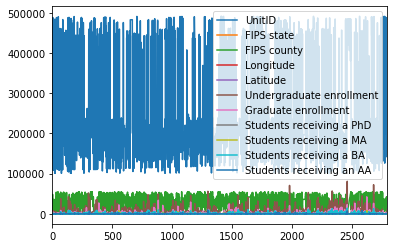

In [8]:
colleges.plot()

`GeoPandas` default is to plot the geometry column.

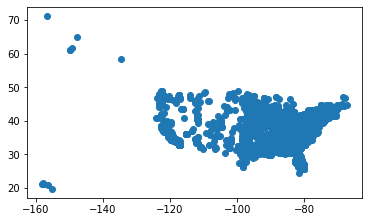

In [9]:
geo_colleges.plot();

You can specify many parameters to make your plot nicer

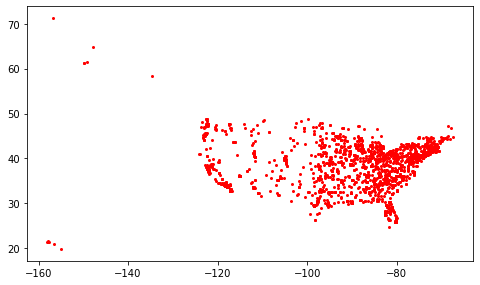

In [10]:
geo_colleges.plot(markersize = 4, color = 'red', figsize = (8,8))

***
Enter, `geoplot`.

`geoplot` is a high-level Python geospatial plotting library. It’s an extension to `cartopy` and `matplotlib` which makes mapping easy: like `seaborn` for geospatial. It comes with the following features:

    High-level plotting API: geoplot is cartographic plotting for the 90% of use cases. All of the standard-bearermaps that you’ve probably seen in your geography textbook are easily accessible.

    Native projection support: The most fundamental peculiarity of geospatial plotting is projection: how do you unroll a sphere onto a flat surface (a map) in an accurate way? The answer depends on what you’re trying to depict. geoplot provides these options.

    Compatibility with matplotlib: While matplotlib is not a good fit for working with geospatial data directly, it’s a format that’s well-incorporated by other tools.


`geoplot` defaults are nicer-looking that `geopandas` defaults

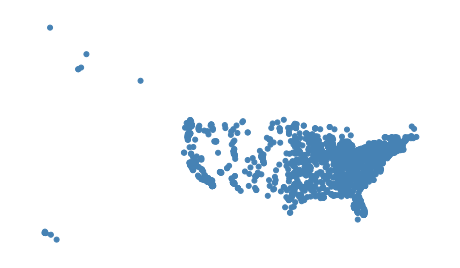

In [11]:
gplt.pointplot(geo_colleges);

and it's easy to change the projection to display your data

In [12]:
import geoplot.crs as gcrs

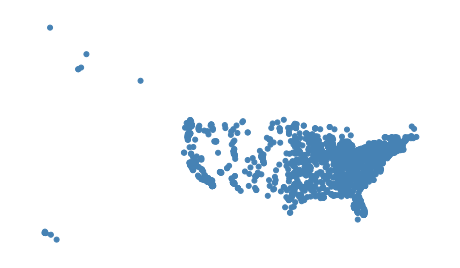

In [13]:
gplt.pointplot(geo_colleges)

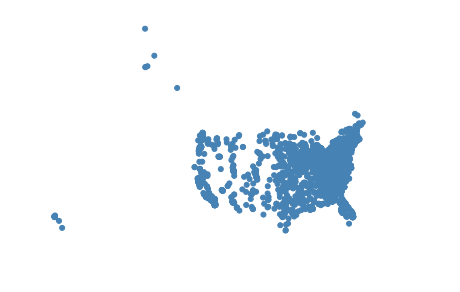

In [14]:
gplt.pointplot(geo_colleges, projection = gcrs.AlbersEqualArea())

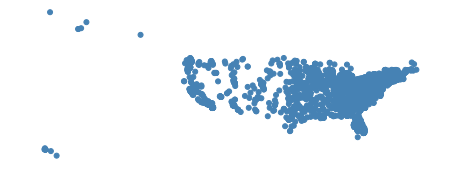

In [15]:
gplt.pointplot(geo_colleges, projection = gcrs.LambertCylindrical())

And even includes _webmaps_

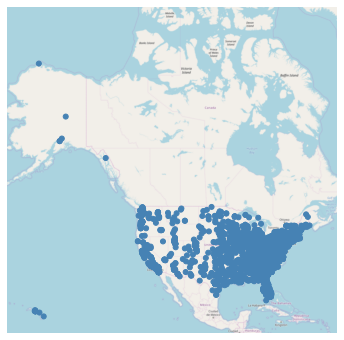

In [16]:
ax = gplt.webmap(geo_colleges, projection=gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax=ax)

***
Since `GeoPandas` is essentially geospatially-enabled `pandas` you can manipulate the dataframe like you would any other dataset.

In [17]:
mask_lower48 = (geo_colleges['State abbreviation'] == 'HI') | (geo_colleges['State abbreviation'] == 'AK')

In [18]:
geo_colleges[mask_lower48].head()

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA,geometry
22,102580,Alaska Bible College,2,PnP,"Under 1,000",Alaska Bible College,248 E Elmwood,Palmer,AK,2170,Matanuska-Susitna Borough,-149.111972,61.598553,42.0,0.0,0,0,3,1,POINT (-149.111972 61.598553)
23,102669,Alaska Pacific University,2,PnP,"Under 1,000",Alaska Pacific University,4101 University Dr,Anchorage,AK,2020,Anchorage Municipality,-149.804168,61.190968,296.0,213.0,3,49,59,4,POINT (-149.804168 61.19096800000001)
105,366748,Argosy University-Hawaii,15,PfP,"Under 1,000",Argosy University-Hawaii,1001 Bishop Street Suite 400,Honolulu,HI,15003,Honolulu County,-157.860432,21.308906,389.0,490.0,55,100,98,15,POINT (-157.860432 21.308906)
300,230047,Brigham Young University-Hawaii,15,PnP,"1,000 - 4,999",Brigham Young University-Hawaii,55-220 Kulanui Street,Laie,HI,15003,Honolulu County,-157.926586,21.642074,3143.0,0.0,0,0,651,243,POINT (-157.926586 21.642074)
449,141486,Chaminade University of Honolulu,15,PnP,"1,000 - 4,999",Chaminade University of Honolulu,3140 Waialae Avenue,Honolulu,HI,15003,Honolulu County,-157.807851,21.289950,1810.0,579.0,0,249,367,53,POINT (-157.807851 21.28995)


In [19]:
geo_colleges[~mask_lower48].head()

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA,geometry
0,177834,A T Still University of Health Sciences,29,PnP,"1,000 - 4,999",A T Still University of Health Sciences,800 W Jefferson,Kirksville,MO,29001,Adair County,-92.589183,40.193648,0.0,3723.0,763,283,0,0,POINT (-92.58918299999999 40.193648)
1,222178,Abilene Christian University,48,PnP,"5,000 - 9,999",Abilene Christian University,NaN,Abilene,TX,48441,Taylor County,-99.709797,32.468943,3666.0,1479.0,3,256,743,3,POINT (-99.70979699999999 32.468943)
2,138558,Abraham Baldwin Agricultural College,13,Public,"1,000 - 4,999",Abraham Baldwin Agricultural College,2802 Moore Hwy,Tifton,GA,13277,Tift County,-83.528281,31.481889,3394.0,0.0,0,0,206,389,POINT (-83.52828100000001 31.481889)
3,488031,Abraham Lincoln University,6,PfP,"Under 1,000",Abraham Lincoln University,3530 Wilshire Boulevard Suite 1430,Los Angeles,CA,6037,Los Angeles County,-118.301362,34.061398,30.0,167.0,17,6,2,0,POINT (-118.301362 34.061398)
4,172866,Academy College,27,PfP,"Under 1,000",Academy College,1600 W. 82nd Street Suite 100,Bloomington,MN,27053,Hennepin County,-93.299809,44.855722,65.0,0.0,0,0,6,16,POINT (-93.299809 44.855722)


In [20]:
geo_colleges = geo_colleges[~mask_lower48].copy()

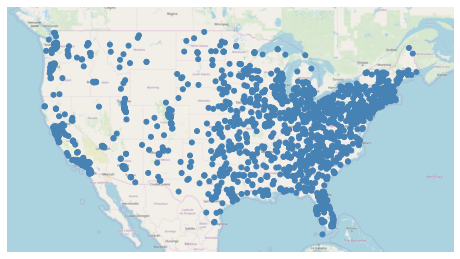

In [21]:
ax = gplt.webmap(geo_colleges, projection = gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax = ax, )

And because it's `matplotlib` under the hood, it's highly customizable.

In [22]:
VAR_OF_INTEREST = 'Undergraduate enrollment'

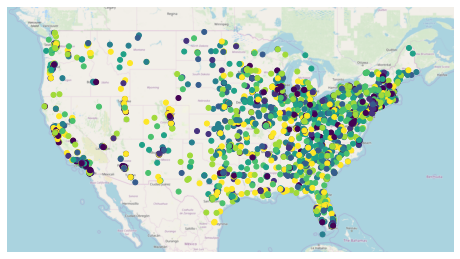

In [23]:
ax = gplt.webmap(geo_colleges, projection = gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax = ax, hue = VAR_OF_INTEREST, k = 8,);

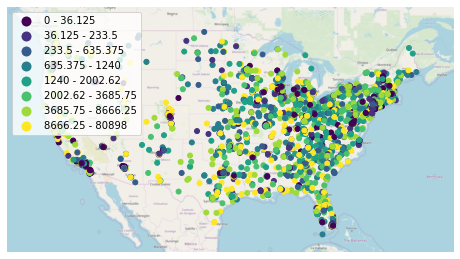

In [24]:
ax = gplt.webmap(geo_colleges, projection = gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax = ax, hue = VAR_OF_INTEREST, k = 8, legend = True);

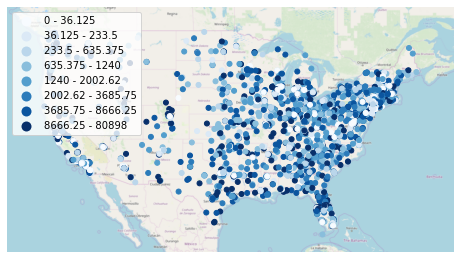

In [25]:
ax = gplt.webmap(geo_colleges, projection = gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax = ax, hue = VAR_OF_INTEREST, k = 8, legend = True, cmap = 'Blues');

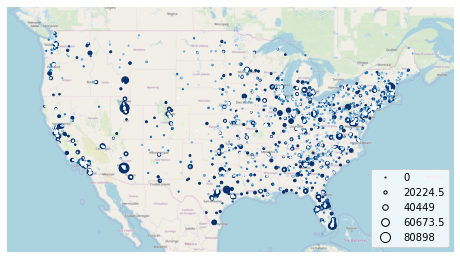

In [26]:
ax = gplt.webmap(geo_colleges, projection = gcrs.WebMercator())
gplt.pointplot(geo_colleges, ax = ax, hue = VAR_OF_INTEREST, k = 5, legend = True, cmap = 'Blues', scale = VAR_OF_INTEREST, legend_var = 'scale', limits = (1, 10));

***
GeoPandas has many useful tools for analysis. 

For example, let's say we wanted to know if there are any areas in the U.S. where there are no 4-year higher education institutions nearby. There, we would be looking at areas and we'll need `polygons` and right now we have only `points` for each of our institutions.

First, step is to see what reference system our data is in.

In [27]:
geo_colleges.crs

Since we created the geometries from a CSV, there's no explicit CRS attatched to our `GeoDataFrame`

In [28]:
geo_colleges.head(2)

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA,geometry
0,177834,A T Still University of Health Sciences,29,PnP,"1,000 - 4,999",A T Still University of Health Sciences,800 W Jefferson,Kirksville,MO,29001,Adair County,-92.589183,40.193648,0.0,3723.0,763,283,0,0,POINT (-92.58918299999999 40.193648)
1,222178,Abilene Christian University,48,PnP,"5,000 - 9,999",Abilene Christian University,NaN,Abilene,TX,48441,Taylor County,-99.709797,32.468943,3666.0,1479.0,3,256,743,3,POINT (-99.70979699999999 32.468943)


But we can see it's using degrees as its unit and if you're familiar with the data you may be able to infer what the CRS is.

In [29]:
geo_colleges.crs = "+init=epsg:4326"

Also, you can check `GeoPandas`' documentation http://geopandas.org/projections.html

Changing a projection in GeoPandas is as simple as using `.to_crs()`

In [30]:
geo_colleges_meters = geo_colleges.to_crs(epsg = 3857)
geo_colleges_meters.head()

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA,geometry
0,177834,A T Still University of Health Sciences,29,PnP,"1,000 - 4,999",A T Still University of Health Sciences,800 W Jefferson,Kirksville,MO,29001,Adair County,-92.589183,40.193648,0.0,3723.0,763,283,0,0,POINT (-10306980.70452522 4894122.711362377)
1,222178,Abilene Christian University,48,PnP,"5,000 - 9,999",Abilene Christian University,NaN,Abilene,TX,48441,Taylor County,-99.709797,32.468943,3666.0,1479.0,3,256,743,3,POINT (-11099643.82914068 3825025.321662576)
2,138558,Abraham Baldwin Agricultural College,13,Public,"1,000 - 4,999",Abraham Baldwin Agricultural College,2802 Moore Hwy,Tifton,GA,13277,Tift County,-83.528281,31.481889,3394.0,0.0,0,0,206,389,POINT (-9298325.707757467 3695491.012801942)
3,488031,Abraham Lincoln University,6,PfP,"Under 1,000",Abraham Lincoln University,3530 Wilshire Boulevard Suite 1430,Los Angeles,CA,6037,Los Angeles County,-118.301362,34.061398,30.0,167.0,17,6,2,0,POINT (-13169247.37799072 4037049.259941264)
4,172866,Academy College,27,PfP,"Under 1,000",Academy College,1600 W. 82nd Street Suite 100,Bloomington,MN,27053,Hennepin County,-93.299809,44.855722,65.0,0.0,0,0,6,16,POINT (-10386087.22898968 5598836.393968724)


Let's look at 4-year institutions in CA.

In [31]:
mask_CA = geo_colleges_meters['State abbreviation'] == 'CA'
ca_colleges = geo_colleges_meters[mask_CA].copy()

In [33]:
ca_colleges.head()

,UnitID,Institution Name,FIPS state,Sector,Size,Institution (entity) name,Address,City,State abbreviation,FIPS county,County name,Longitude,Latitude,Undergraduate enrollment,Graduate enrollment,Students receiving a PhD,Students receiving a MA,Students receiving a BA,Students receiving an AA,geometry
3,488031,Abraham Lincoln University,6,PfP,"Under 1,000",Abraham Lincoln University,3530 Wilshire Boulevard Suite 1430,Los Angeles,CA,6037,Los Angeles County,-118.301362,34.061398,30.0,167.0,17,6,2,0,POINT (-13169247.37799072 4037049.259941264)
6,457271,Academy for Jewish Religion-California,6,PnP,"Under 1,000",Academy for Jewish Religion-California,574 Hilgard Avenue,Los Angeles,CA,6037,Los Angeles County,-118.438495,34.070281,0.0,53.0,0,11,0,0,POINT (-13184512.95372168 4038242.955820376)
7,108232,Academy of Art University,6,PfP,"10,000 - 19,999",Academy of Art University,79 New Montgomery,San Francisco,CA,6075,San Francisco County,-122.400686,37.787748,7652.0,4020.0,0,1270,1065,235,POINT (-13625582.03826737 4549484.963026268)
8,108269,Academy of Chinese Culture and Health Sciences,6,PnP,"Under 1,000",Academy of Chinese Culture and Health Sciences,1600 Broadway Ste. 200,Oakland,CA,6001,Alameda County,-122.269839,37.805972,0.0,99.0,0,24,0,0,POINT (-13611016.21685554 4552052.307604087)
9,384306,Acupuncture and Integrative Medicine College-B...,6,PnP,"Under 1,000",Acupuncture and Integrative Medicine College-B...,2550 Shattuck Avenue,Berkeley,CA,6001,Alameda County,-122.267636,37.862754,0.0,81.0,0,26,0,0,POINT (-13610770.98001733 4560055.657430588)


To be able to map that on our webmaps we'll change the CRS back to 4326

In [57]:
ca_colleges = ca_colleges.to_crs(epsg = 4326)

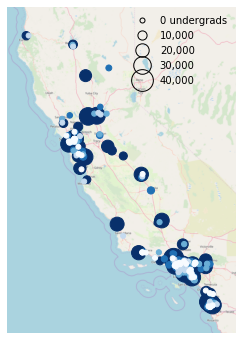

In [58]:
ax = gplt.webmap(ca_colleges, projection = gcrs.WebMercator())
gplt.pointplot(ca_colleges, ax = ax, hue = VAR_OF_INTEREST, k = 5, legend = True, cmap = 'Blues', scale = VAR_OF_INTEREST, legend_var = 'scale', limits = (5,20), legend_kwargs={'frameon': False, 'loc': 'upper right'}, legend_values=[0, 10000, 20000, 30000, 40000],
    legend_labels=['0 undergrads', '10,000', '20,000', '30,000', '40,000'],
);

One way to look at it it's through a Kernel Density Estimation plot (or KDE plot)

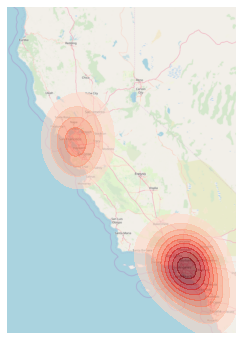

In [60]:
ax = gplt.webmap(ca_colleges, zorder=1, projection= gcrs.WebMercator())
gplt.kdeplot(ca_colleges,  cmap='Reds', shade=True, ax = ax, alpha = 0.6)

A _more accurate_ way to do this would be to create actual X-mile areas around each of the institutions. 

This is how you'd do that in `GeoPandas`

First, we transform our GeoDataFrame to epsg 3857 which uses meters as its unit of measure, create a 50-mile buffer and transform that back to epsg 4326 so we can map that using our webmaps.

In [66]:
areas = ca_colleges.to_crs(epsg = 3857)['geometry'].buffer(50 * 1609).to_crs(epsg = 4326)

In [67]:
areas.head()

3    POLYGON ((-117.5786673539259 34.061398, -117.5...
6    POLYGON ((-117.7158003539258 34.07028099999999...
7    POLYGON ((-121.6779913539258 37.78774799999999...
8    POLYGON ((-121.5471443539258 37.80597199999998...
9    POLYGON ((-121.5449413539259 37.86275399999999...
dtype: object

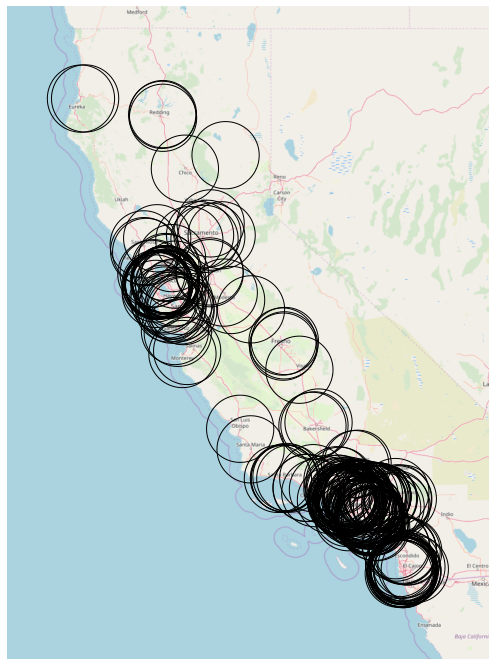

In [68]:
ax = gplt.webmap(areas, figsize=(12,12), projection = gcrs.WebMercator(), zorder=1)
gplt.polyplot(areas, ax = ax, edgecolor = 'black', zorder = 2)

In [79]:
areas = gpd.GeoDataFrame(areas)

areas.columns = ['geometry']

areas.head()

In [82]:
areas['50-mile radius'] = 'Yes'

In [83]:
areas.head()

,geometry,50-mile radius
3,"POLYGON ((-117.5786673539259 34.061398, -117.5...",Yes
6,POLYGON ((-117.7158003539258 34.07028099999999...,Yes
7,POLYGON ((-121.6779913539258 37.78774799999999...,Yes
8,POLYGON ((-121.5471443539258 37.80597199999998...,Yes
9,POLYGON ((-121.5449413539259 37.86275399999999...,Yes


In [85]:
areas_agg = areas.dissolve(by = '50-mile radius')

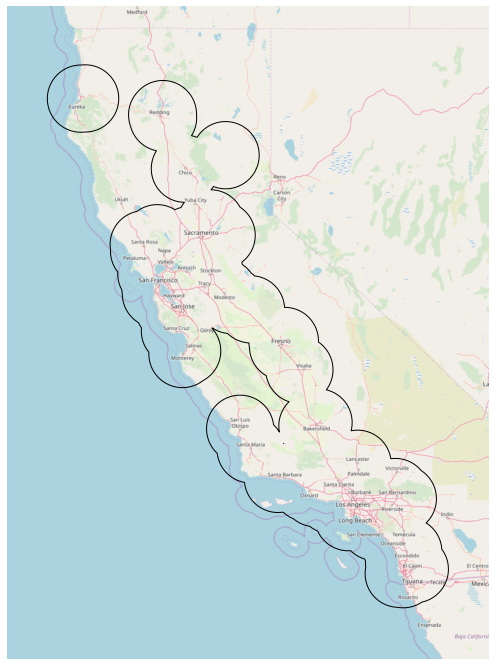

In [86]:
ax = gplt.webmap(areas_agg, figsize=(12,12), projection = gcrs.WebMercator(), zorder=1)
gplt.polyplot(areas_agg, ax = ax, edgecolor = 'black', zorder = 2)

In [96]:
ca = contiguous_usa[contiguous_usa['state'] == 'California']

In [97]:
ca

,state,adm1_code,population,geometry
6,California,USA-3521,37253956,"POLYGON ((-114.354901 34.464667, -114.165972 3..."


In [98]:
clipped_areas = gpd.overlay(areas_agg, ca, how = 'intersection')

C:\Users\sanchez\AppData\Local\Continuum\anaconda3\envs\NACIS2019\lib\site-packages\geopandas\base.py:35: UserWarning: GeoSeries crs mismatch: None and {'init': 'epsg:4326'}
  right.crs))


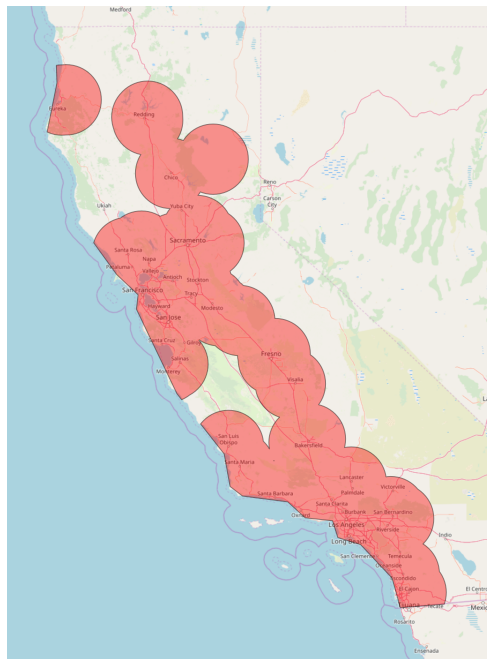

In [99]:
ax = gplt.webmap(clipped_areas, figsize=(12,12), projection = gcrs.WebMercator(), zorder=1)
gplt.polyplot(clipped_areas, ax = ax, edgecolor = 'black', zorder = 2, facecolor = 'red', alpha = 0.4)

In [102]:
missing_areas = gpd.overlay(clipped_areas, ca, how = "symmetric_difference")

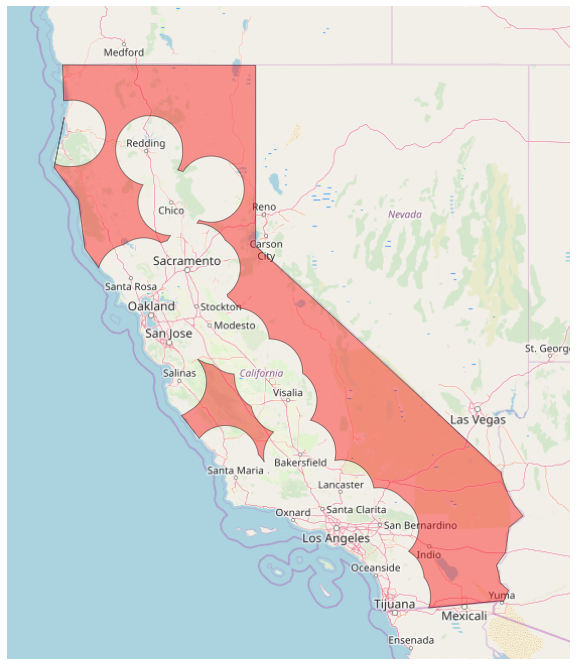

In [103]:
ax = gplt.webmap(missing_areas, figsize=(12,12), projection = gcrs.WebMercator(), zorder=1)
gplt.polyplot(missing_areas, ax = ax, edgecolor = 'black', zorder = 2, facecolor = 'red', alpha = 0.4)

***
# Rest of US?

In [104]:
us_areas = geo_colleges.to_crs(epsg = 3857)['geometry'].buffer(50 * 1609).to_crs(epsg = 4326)

In [107]:
us_areas = gpd.GeoDataFrame(us_areas)

us_areas.columns = ['geometry']

us_areas['50-mile radius'] = 'Yes'

us_areas.head()

,geometry,50-mile radius
0,POLYGON ((-91.86648835392583 40.19364799999998...,Yes
1,POLYGON ((-98.98710235392583 32.46894299999997...,Yes
2,POLYGON ((-82.80558635392585 31.48188899999998...,Yes
3,"POLYGON ((-117.5786673539259 34.061398, -117.5...",Yes
4,POLYGON ((-92.57711435392584 44.85572199999999...,Yes


In [114]:
us_areas_agg = us_areas.dissolve(by = '50-mile radius')
us_areas.crs = {"init": "epsg:4326"}

In [115]:
clipped_us_areas = gpd.overlay(us_areas_agg, contiguous_usa, how = 'intersection')

C:\Users\sanchez\AppData\Local\Continuum\anaconda3\envs\NACIS2019\lib\site-packages\geopandas\base.py:35: UserWarning: GeoSeries crs mismatch: None and {'init': 'epsg:4326'}
  right.crs))


In [116]:
missing_us_areas = gpd.overlay(clipped_us_areas, contiguous_usa, how = "symmetric_difference")

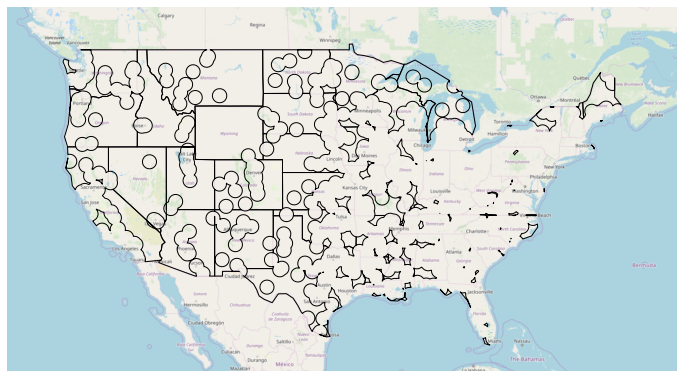

In [122]:
ax = gplt.webmap(missing_us_areas, figsize=(12,12), projection = gcrs.WebMercator(), zorder=1)
gplt.polyplot(missing_us_areas, ax = ax, edgecolor = 'black', zorder = 2,  )